In [ ]:
import pandas as pd
import numpy as np
import torch
import cv2
from google.colab.patches import cv2_imshow
from IPython.display import display
import sys

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')
root_path = '/content/drive/MyDrive/DLIP'  #change dir to your project folder
os.chdir(root_path)  #change dir
os.getcwd()

Mounted at /content/drive


'/content/drive/MyDrive/DLIP'

In [ ]:
!pip install ultralytics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.2/611.2 kB 37.2 MB/s eta 0:00:00


In [ ]:
import cv2
from matplotlib import pyplot as plt
import time
from pathlib import Path
from PIL import Image

In [ ]:
# Load YOLOv5 model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = torch.hub.load('ultralytics/yolov5', 'custom', path='best.pt')

# Resetting the frame count
frame_count = 0

# Initialize the start time
start_time = 0

# DLIP_calories.csv file
df = pd.read_csv('DLIP_calories.csv')

#Initialize color
sky_blue = (255,191,0)
lime_green = (0,255,227)
color=['lightblue','lightgreen','pink']

total_calories =0
total_carbohydrates = 0
total_protein = 0
total_fat = 0

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-6-19 Python-3.10.12 torch-2.0.1+cu118 CPU

Fusing layers... 
Model summary: 267 layers, 46189053 parameters, 0 gradients
Adding AutoShape... 


In [ ]:

def detect_objects(image):
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# setting confidenc = 0.1
  model.conf = 0.1
  results = model(image) # detect object


  process_results(results, image)

  # image show
  image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
  resized_image = cv2.resize(image, None, fx=1, fy=1, interpolation=cv2.INTER_LINEAR)
  cv2.imwrite("Detection_image.png", resized_image)

  return 'Detection_image.png'


In [ ]:
def process_results(results, image):

    global total_caloreis
    global total_carbohydrates
    global total_protein
    global total_fat


    # Get Object Information from Results
    objects = results.pandas().xyxy[0]
    # Output object information
    print(objects)

    # Draw object information on images
    for _, obj in objects.iterrows():
        label = obj['name']
        confidence = obj['confidence']
        x_min = int(obj['xmin'])
        y_min = int(obj['ymin'])
        x_max = int(obj['xmax'])
        y_max = int(obj['ymax'])

        #Calculate Calories and Nutrients of Detected Objects
        if label in df['food name'].values:
            food_data = df[df['food name'] == label].iloc[0]
            caloreis = food_data['energy(kcal)']
            carbohydrates = food_data['carbohydrates(g)']
            protein = food_data['protein(g)']
            fat = food_data['fat(g)']

            total_caloreis += caloreis
            total_carbohydrates += carbohydrates
            total_protein += protein
            total_fat += fat

        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), lime_green, 2)
        cv2.putText(image, f'{label}: {confidence:.4f}', (x_min, y_min - 10),cv2.FONT_HERSHEY_SIMPLEX, 0.9, lime_green, 2)

    print(f'process result:{total_caloreis}')


In [ ]:
def total_nutrients(total_carbohydrates, total_protein, total_fat):

  values=[]
  ratios=[]
  remain=[]

  '''
  Plot Total nutrient
  '''
  values = [total_carbohydrates, total_protein, total_fat]
  recommended_values = [130, 55, 25]
  nutrients = ['Total carbohydrates', 'Total protein', 'Total fat']

 #Calculate the percentage of nutrients consumed based on the recommended calorie intake
  ratios = [(v / r)*100 for v, r in zip(values, recommended_values)]
  remain = [100-per for per in ratios]
  color=['lightblue','lightgreen','pink']
  plt.clf()
  bar = plt.bar(nutrients,ratios,color=color)
  plt.bar(nutrients,remain,bottom = ratios, color='lightgray')

# Convert graph to image and output
  fig_nutrients = plt.gcf()
  plt.title('Total Nutrients intake')
  plt.xlabel('Nutrients')
  plt.ylabel('percentage(%)')


# Insert values ​​into the graph
  for rect in bar:
      height = rect.get_height()
      plt.text(rect.get_x() + rect.get_width()/2.0, height, '%.1f' % height, ha='center', va='bottom', size = 12)

  plt.ylim(0, 100)
  plt.tight_layout()
  plt.savefig("Total nutrient.png")
  plt.close()

  return 'Total nutrient.png'


In [ ]:
def total_calory_oneday(total):

  #Calculate total calories consumed per day
  print(f'total:{total}')

  oneday_caloreis=[]
  oneday_cal = total
  remain_total_cal = 2100 - oneday_cal
  oneday_caloreis= [oneday_cal,remain_total_cal]
  labels = ['intake', 'reamin']
  pie_colors = ['#d395d0', 'lightgray']
  wedgeprops={'width': 0.7, 'edgecolor': 'w', 'linewidth': 5}


  plt.clf()
  fig_calories = plt.gcf()

  # Setting wedgeprops to empty the middle part
  wedgeprops = {'width': 0.6}
  plt.pie(oneday_caloreis, labels=labels, autopct='%.1f%%', startangle=260, counterclock=False, colors=pie_colors, wedgeprops=wedgeprops)
  plt.text(0, 0, f'{total_caloreis:.0f}kcal\n',fontname='monospace', fontsize=20, fontweight='bold',color='black', ha='center', va='center')
  plt.text(0, 0, f'\n/2100', fontsize=12, color='black', ha='center', va='center')
  plt.tight_layout()
  plt.title('Total Calories')
  plt.savefig("Total Calories.png")
  plt.close()
  return 'Total Calories.png'

In [ ]:
def merge_images(image_paths):

    # Open the first image
    images = [Image.open(path) for path in image_paths]
    widths, heights = zip(*(i.size for i in images))

    # Calculate the size of the new image
    new_width = sum(widths)
    new_height = max(heights)

    # Create a new image
    new_image = Image.new('RGB', (new_width, new_height))

    # Paste the images onto the new image
    x_offset = 0
    for image in images:
        new_image.paste(image, (x_offset, 0))
        x_offset += image.width

    # Save the resulting image
    new_image.save('merge.jpg')

    return 'merge.jpg'


In [ ]:
def open_file(input_path):

  global total_caloreis
  global total_carbohydrates
  global total_protein
  global total_fat

  total_caloreis = 0
  total_carbohydrates = 0
  total_protein = 0
  total_fat = 0

  if len(input_path) > 1:
    input_path = merge_images(input_path)
  else :
    input_path = input_path[0]

  # open video file
  if input_path.endswith('.mp4') or input_path.endswith('.avi'):

    vid = cv2.VideoCapture(input_path)

    #height, width, channels = frame.shape
    height = int(vid.get(cv2.CAP_PROP_FRAME_HEIGHT))
    width  = int(vid.get(cv2.CAP_PROP_FRAME_WIDTH))

    while True:
      ret, frame = vid.read()
      if not ret:
        print('video in not open')
        break

      resized_frame = detect_objects(frame)
      cv2_imshow(resized_frame)
      if vid.get(cv2.CAP_PROP_POS_FRAMES) == vid.get(cv2.CAP_PROP_FRAME_COUNT):
        break

      if cv2.waitKey(1) == ord('q'):
        break

      vid.release()

  else:
    img = cv2.imread(input_path) # open image file

    if img is None:
      print("The image is empty. Exiting debugging.")
      sys.exit()


    png_resized_image = detect_objects(img) # detect food

    png_total_nutrients = total_nutrients(total_carbohydrates, total_protein, total_fat) # plot onday nutrient

    png_total_calory_oneday = total_calory_oneday(total_caloreis) # plot onday caloeris

    return png_resized_image, png_total_nutrients, png_total_calory_oneday

In [ ]:
def week_dfappend(week_nutrient, date, calories, carbohydrates, protein,fat):

  new_data = {
    'date': [date],
    'calories': [calories],
    'carbohydrates': [carbohydrates],
    'protein': [protein],
    'fat': [fat]
  }
  new_row = pd.DataFrame(new_data)
  week_nutrient = week_nutrient.append(new_row, ignore_index=True) # add the day nutrient information
  print(week_nutrient)

  return week_nutrient


In [ ]:
def plot_oneday(day, png_resized_image, png_total_nutrients, png_total_calory_oneday):

  plt.clf()
  # Create a plot
  fig_plot_oneday, axs = plt.subplots(1, 3, figsize=(18, 6))

  # Display each PNG file on the plot
  #Display detection image
  img_resized = Image.open(png_resized_image)
  axs[0].imshow(img_resized)
  axs[0].axis('off')
  axs[0].set_title("Detection Image")
  #Display nutrient
  img_nutrients = Image.open(png_total_nutrients)
  axs[1].imshow(img_nutrients)
  axs[1].axis('off')
  axs[1].set_title("Total Nutrients")
  #Display total calories
  img_calory = Image.open(png_total_calory_oneday)
  axs[2].imshow(img_calory)
  axs[2].axis('off')
  axs[2].set_title("Total Calories One Day")

  image = fig_plot_oneday
  display(image)

  outpath = "plot_oneday_" + day + ".png"
  plt.savefig(outpath)


In [ ]:
def plot_week(week_nutrient):

  plt.clf()
  # 1x2 subplot
  fig_plot_week, axs = plt.subplots(1, 2, figsize=(12, 4))
  '''
  Calories in a week
  '''

  x = week_nutrient['date']
  y = week_nutrient['calories']
  max_value = week_nutrient['calories'].max()
  axs[0].plot(x, y, 'o-', color='violet')
  axs[0].set_ylim(0, max_value * 1.2)
  for i in range(len(x)):
      height = y[i]
      axs[0].text(x[i], height + 0.25, '%.1f' % height, ha='center', va='bottom', size=12)
  axs[0].set_title('Calories in a week')
  axs[0].set_xlabel('Day of the week')
  axs[0].set_ylabel('Calories (kcal)')
  '''
  Nutrient in a week
  '''
  y_nut = week_nutrient[['carbohydrates', 'protein', 'fat']]
  axs[1].plot(x, y_nut['carbohydrates'], 'o-', color=color[0],label='carbohydrates')
  axs[1].plot(x, y_nut['protein'], 'o-', color=color[1],label='protein')
  axs[1].plot(x, y_nut['fat'], 'o-', color=color[2],label='fat')
  axs[1].legend()
  max_value_nut = y_nut['carbohydrates'].max()
  axs[1].set_ylim(0, max_value_nut * 1.2)

  axs[1].set_title('Nutrient in a week')
  axs[1].set_xlabel('Day of the week')
  axs[1].set_ylabel('Weight (g)')

  display(fig_plot_week)
  plt.close()

         xmin        ymin        xmax        ymax  confidence  class  \
0   89.973793    9.752072  255.817505  231.538986    0.884220     15   
1  674.704590    7.521040  921.091553  232.858047    0.838777      8   
2  308.646301   17.145735  507.498932  224.382324    0.833018      5   
3  634.739929  313.187195  965.467163  609.338989    0.796825      7   
4    1.047357  297.858032  496.476685  608.844849    0.762034      9   
5  511.560150   52.316875  649.311340  209.691696    0.180692      6   

                   name  
0  vegetable croquettes  
1  meat sauce spaghetti  
2      dolnamul chojang  
3          kongnamulgug  
4               ssalbab  
5                kimchi  
process result:692.9300000000001
total:692.9300000000001


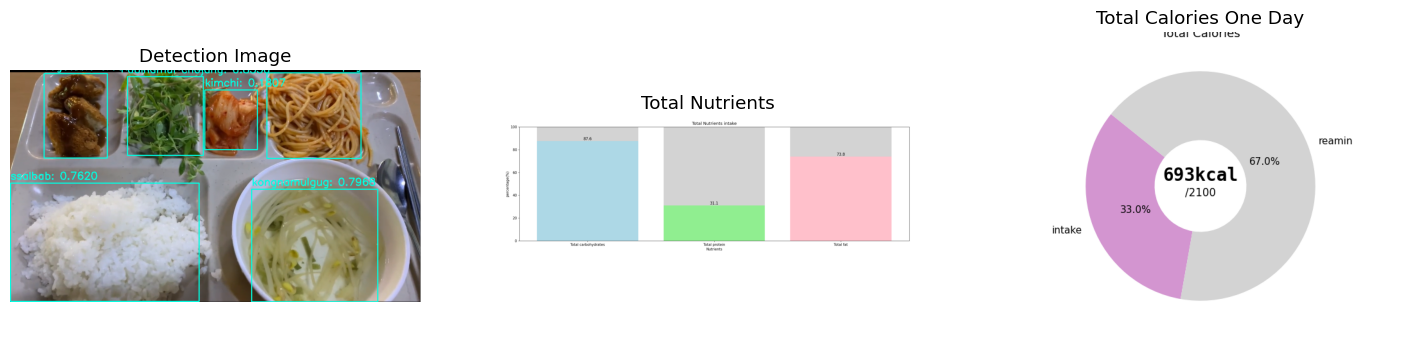

In [ ]:
import matplotlib.image as mpimg

columns = ['date', 'calories', 'carbohydrates', 'protein', 'fat']
week_nutrient= pd.DataFrame(columns=columns)
# 객체 인식 수행
mon_input_path = ['0603.png']

mon_resized_image, mon_total_nutrients, mon_total_calory_oneday = open_file(mon_input_path)

plot_oneday("Mon",mon_resized_image, mon_total_nutrients, mon_total_calory_oneday)

In [ ]:
week_nutrient = week_dfappend(week_nutrient,'Mon',total_caloreis,total_carbohydrates,total_protein,total_fat)

  date  calories  carbohydrates  protein    fat
0  Mon    692.93         113.92    17.13  18.46


<ipython-input-111-9f233cb77611>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  week_nutrient = week_nutrient.append(new_row, ignore_index=True)


        xmin       ymin         xmax         ymax  confidence  class  \
0  33.216648  263.19632  1042.484497  1213.078613    0.413025      4   

                name  
0  chicken mayo rice  
process result:686.0
total:686.0
        xmin       ymin         xmax         ymax  confidence  class  \
0  33.216648  263.19632  1042.484497  1213.078613    0.413025      4   

                name  
0  chicken mayo rice  
process result:686.0
total:686.0


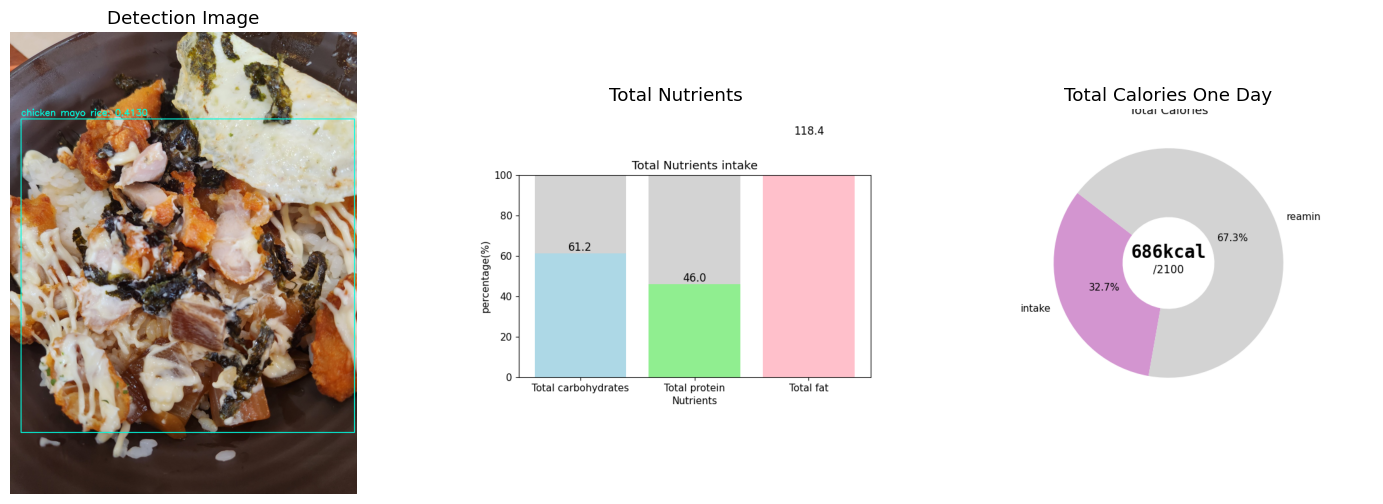

In [ ]:

Tue_input_path = ['chickenmayo.jpg']
open_file(Tue_input_path)
Tue_resized_image, Tue_total_nutrients, Tue_total_calory_oneday = open_file(Tue_input_path)

plot_oneday("Tue",Tue_resized_image, Tue_total_nutrients, Tue_total_calory_oneday)

In [ ]:
week_nutrient = week_dfappend(week_nutrient,'Tue',total_caloreis,total_carbohydrates,total_protein,total_fat)

  date  calories  carbohydrates  protein    fat
0  Mon    692.93         113.92    17.13  18.46
1  Tue    686.00          79.58    25.32  29.60


<ipython-input-111-9f233cb77611>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  week_nutrient = week_nutrient.append(new_row, ignore_index=True)


          xmin         ymin         xmax         ymax  confidence  class  \
0  1168.887329  1068.598511  3466.361084  2056.470947    0.838444     13   
1    48.208370   130.830917  1004.216797  1304.305054    0.633383      0   

           name  
0   tteogkkochi  
1  Cheese Pizza  
process result:377.0
total:377.0
          xmin         ymin         xmax         ymax  confidence  class  \
0  1168.887329  1068.598511  3466.361084  2056.470947    0.838444     13   
1    48.208370   130.830917  1004.216797  1304.305054    0.633383      0   

           name  
0   tteogkkochi  
1  Cheese Pizza  
process result:377.0
total:377.0


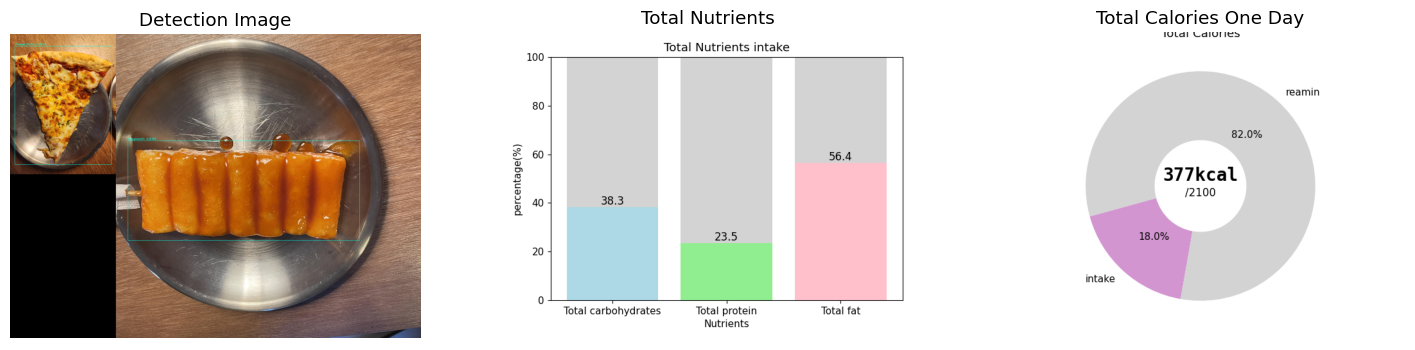

In [ ]:

Wed_input_path = ['cheeze.jpg','kochi.jpg']
open_file(Wed_input_path)
Wed_resized_image, Wed_total_nutrients, Wed_total_calory_oneday = open_file(Wed_input_path)

plot_oneday("Wed",Wed_resized_image, Wed_total_nutrients, Wed_total_calory_oneday )

In [ ]:
week_nutrient = week_dfappend(week_nutrient,'Wed',total_caloreis,total_carbohydrates,total_protein,total_fat)

  date  calories  carbohydrates  protein    fat
0  Mon    692.93         113.92    17.13  18.46
1  Tue    686.00          79.58    25.32  29.60
2  Wed    377.00          49.73    12.90  14.09


<ipython-input-111-9f233cb77611>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  week_nutrient = week_nutrient.append(new_row, ignore_index=True)


         xmin        ymin         xmax         ymax  confidence  class  \
0   36.552559   35.295116   302.747009   359.938141    0.762649     14   
1  436.887909  142.256531  1316.954468  1055.154297    0.166915     12   

         name  
0  tteokbokki  
1      sundae  
process result:829.0
total:829.0
         xmin        ymin         xmax         ymax  confidence  class  \
0   36.552559   35.295116   302.747009   359.938141    0.762649     14   
1  436.887909  142.256531  1316.954468  1055.154297    0.166915     12   

         name  
0  tteokbokki  
1      sundae  
process result:829.0
total:829.0


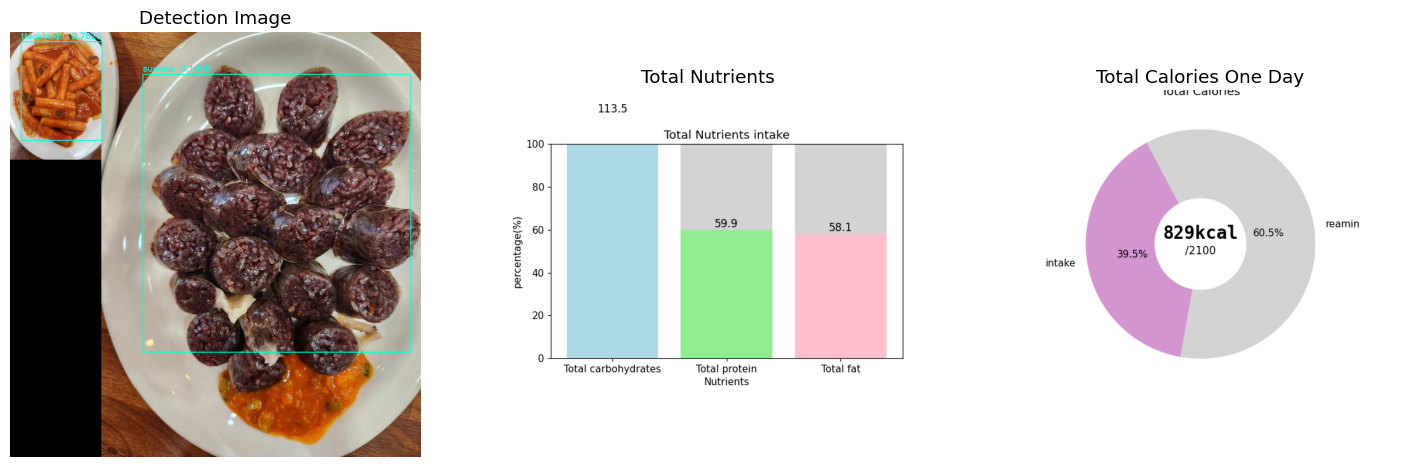

In [ ]:
Thu_input_path = ['tteockbocki.jpg','sundae.jpg']
open_file(Thu_input_path)
Thu_resized_image, Thu_total_nutrients, Thu_total_calory_oneday = open_file(Thu_input_path)

plot_oneday("Thu",Thu_resized_image, Thu_total_nutrients, Thu_total_calory_oneday )

In [ ]:
week_nutrient = week_dfappend(week_nutrient,'Thu',total_caloreis,total_carbohydrates,total_protein,total_fat)

  date  calories  carbohydrates  protein    fat
0  Mon    692.93         113.92    17.13  18.46
1  Tue    686.00          79.58    25.32  29.60
2  Wed    377.00          49.73    12.90  14.09
3  Thu    829.00         147.51    32.97  14.52


<ipython-input-111-9f233cb77611>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  week_nutrient = week_nutrient.append(new_row, ignore_index=True)


In [ ]:
import ipywidgets as widgets

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode


def take_photo(filename='photo.jpg', quality=0.8):
  #Start writing javascript
  js = Javascript('''
    async function takePhoto(quality) {

      //Create a div (space)
      const div = document.createElement('div');

      //create button
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      //create video
      const video = document.createElement('video');
      //video shape square
      video.style.display = 'block';
      //Calling up the camera (webcam)
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      //Add child space below the div
      document.body.appendChild(div);
      //put video in space
      div.appendChild(video);
      //Connect video and webcam
      video.srcObject = stream;
      //await -> asynchronous processing (related to thread) (async and set)
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      //create canvas
      const canvas = document.createElement('canvas');
      //fit to size
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      //draw image
      canvas.getContext('2d').drawImage(video, 0, 0);
      //turn off video
      stream.getVideoTracks()[0].stop();
      //delete div
      div.remove();
      // return file address
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  #Send the return value of #javascript code execution to Python
  data = eval_js('takePhoto({})'.format(quality))
  # Save data as base64 when saving data from web browser
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


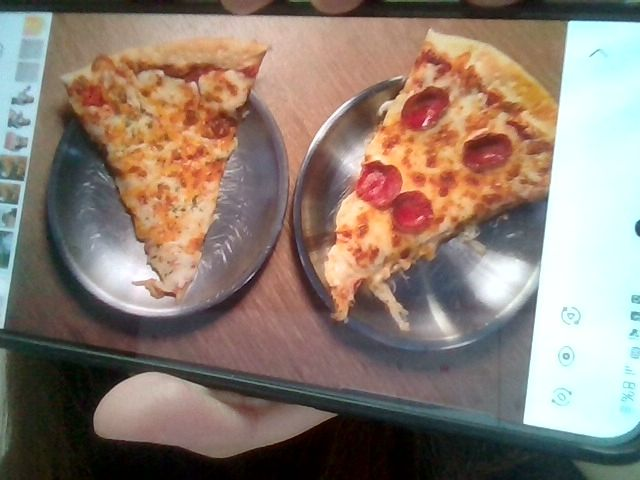

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))


         xmin       ymin        xmax        ymax  confidence  class  \
0   58.395462  43.723679  267.884094  305.201782    0.765592      0   
1  304.534973  41.827454  548.036804  321.021118    0.162206      1   

              name  
0     Cheese Pizza  
1  Pepperoni Pizza  
process result:535.0
total:535.0
         xmin       ymin        xmax        ymax  confidence  class  \
0   58.395462  43.723679  267.884094  305.201782    0.765592      0   
1  304.534973  41.827454  548.036804  321.021118    0.162206      1   

              name  
0     Cheese Pizza  
1  Pepperoni Pizza  
process result:535.0
total:535.0


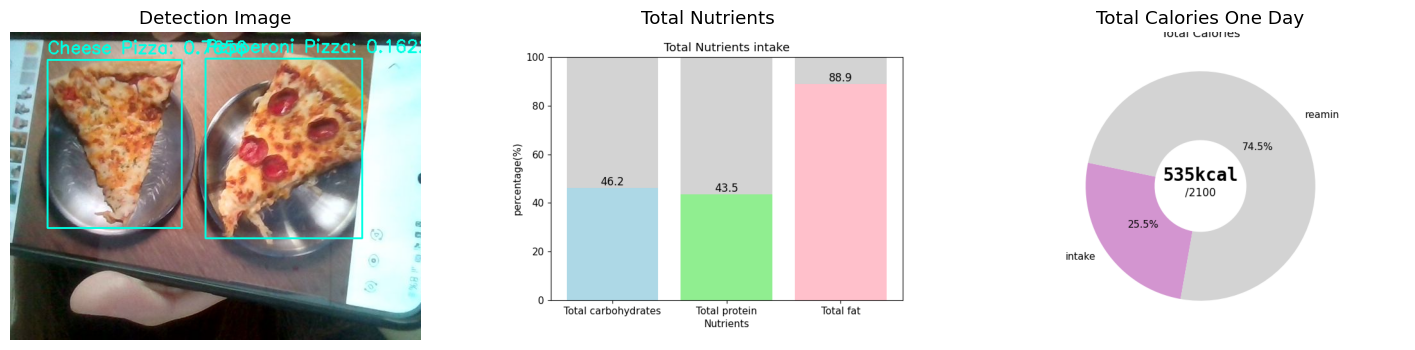

In [ ]:
from PIL import Image
# 객체 인식 수행
Fri_input_path =[format(filename)]
open_file(Fri_input_path)
Fri_resized_image, Fri_total_nutrients, Fri_total_calory_oneday = open_file(Fri_input_path)

plot_oneday("Fri",Fri_resized_image, Fri_total_nutrients, Fri_total_calory_oneday )

In [ ]:
week_nutrient = week_dfappend(week_nutrient,'Fri',total_caloreis,total_carbohydrates,total_protein,total_fat)

  date  calories  carbohydrates  protein    fat
0  Mon    692.93         113.92    17.13  18.46
1  Tue    686.00          79.58    25.32  29.60
2  Wed    377.00          49.73    12.90  14.09
3  Thu    829.00         147.51    32.97  14.52
4  Fri    535.00          60.06    23.92  22.23


<ipython-input-111-9f233cb77611>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  week_nutrient = week_nutrient.append(new_row, ignore_index=True)


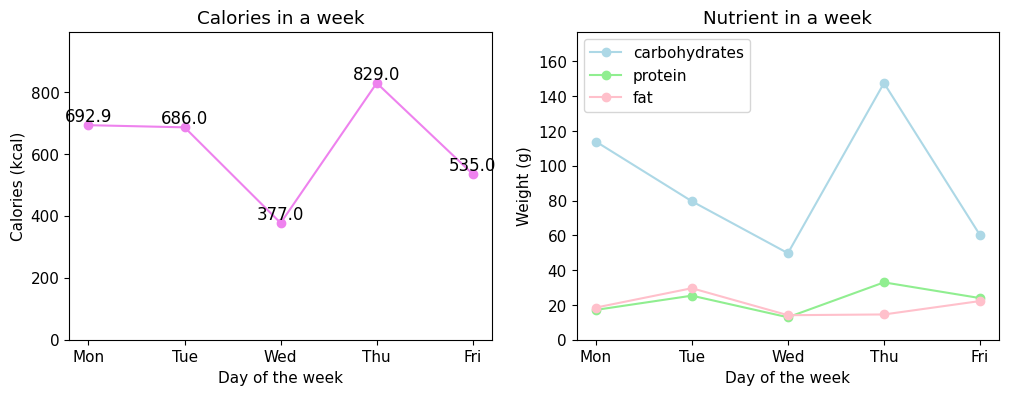

In [ ]:
plot_week(week_nutrient)

In [ ]:
cv2.waitKey(0)
cv2.destroyAllWindows()